# Average Precision Evaluation for Qdrant Vector Search

## Question

In this notebook, we will evaluate the accuracy of the approximate search for our existing collection by calculating the average precision@k and compare the speed of the exact search and the approximate search with a small test dataset.

## Theory

By default, Qdrant uses the HNSW index for fast Approximate Nearest Neighbor (ANN) searches. This method returns results that are close to the actual nearest neighbors, but it is not exact. It is suitable for large datasets where doing an exact search would be expensive.

Exact k-Nearest Neighbor (k-NN) search involves searching the entire dataset to find the true nearest neighbors. While this approach is slower and is not suitable for production use, it provides precise results. The exact k-NN search serves as a baseline for evaluating the accuracy of ANN search, allowing for comparisons of the trade-offs between speed and precision.

Precision@k is a metric that measures the quality of the search results and focuses on the relevance of items retrieved during the ANN search, and is calculated as:

$$\text{Precision@k} = \frac{|\text{ANN results} \cap \text{Exact results}|}{k}$$

A value of 1 indicates that all approximate search results are identical to the exact search results. High precision means fewer irrelevant or false-positive items are included. k here corresponds to the number of retrieved items (we use 10). Precision measures the quality of the retrieved results by assessing the proportion of retrieved items that are actually relevant. It answers the question:

"Out of all the items the search retrieved, how many are true nearest neighbors?"


In [1]:
# Import necessary libraries
import json
import time
from typing import List, Dict, Set
import pandas as pd

# Import from qdrant_evaluation module
from qdrant_evaluation.client import get_client
from qdrant_evaluation.evaluator import (
    evaluate_ann,
    get_ann_points,
    get_knn_points,
    precision_k,
    results_to_dataframe
)


In [8]:
# Define constants
QDRANT_HOST = "localhost"
QDRANT_PORT = 6333
COLLECTION_NAME = 'arxiv_papers'
k = 10
QUERIES_FILE = "/Users/danielwirth/PycharmProjects/Qdrant Further Steps/docs/01_evaluate_precision/queries_embeddings.json"

# Initialize Qdrant client
client = get_client(host=QDRANT_HOST, port=QDRANT_PORT)


## Load Test Dataset

We'll load a test dataset from the ml-arxiv-embeddings.json file, which contains arXiv paper metadata and their corresponding embeddings. Each paper has an ID, title, abstract, and embedding vector. We'll extract the paper IDs and their embeddings to create a dictionary, and limit it to 100 papers for our evaluation.


In [9]:
def get_test_data_set() -> str:
    with open(QUERIES_FILE, 'r', encoding='utf-8') as file:
        test_dataset = json.load(file)
        return test_dataset

In [10]:
# Load the embeddings
embeddings = get_test_data_set()



## Evaluate Precision and Search Performance

Now we'll evaluate the precision of the approximate search compared to the exact search, and measure the performance of both search methods.


In [11]:
# Function to format results
def result_formatting(k, avg_precision, avg_ann_time, avg_knn_time):
    """Format and print evaluation results"""
    print(f'Average precision@{k}: {avg_precision:.4f}')
    print(f'Average ANN query time: {avg_ann_time * 1000:.2f} ms')
    print(f'Average exact k-NN query time: {avg_knn_time * 1000:.2f} ms')
    print(f'Speedup ratio (k-NN / ANN): {avg_knn_time / avg_ann_time:.2f}x')


In [12]:
# Evaluate ANN search performance
def evaluate_search_performance():
    """Evaluate search performance and precision"""
    # Get ANN and KNN results for each embedding
    ann_results = [get_ann_points(client, COLLECTION_NAME, vector) for _, vector in embeddings.items()]
    knn_results = [get_knn_points(client, COLLECTION_NAME, vector) for _, vector in embeddings.items()]

    # Calculate precision and collect execution times
    results = []
    for (ann_id_list, ann_execution_time), (knn_id_list, knn_execution_time) in zip(ann_results, knn_results):
        precision = precision_k(set(ann_id_list), set(knn_id_list))
        results.append({
            "precision": precision,
            "ann_time": ann_execution_time,
            "knn_time": knn_execution_time
        })

    # Calculate averages
    avg_precision = sum(r["precision"] for r in results) / len(results)
    avg_ann_time = sum(r["ann_time"] for r in results) / len(results)
    avg_knn_time = sum(r["knn_time"] for r in results) / len(results)

    # Format and print results
    result_formatting(k, avg_precision, avg_ann_time, avg_knn_time)

    # Return results as a dictionary
    return {
        "avg_precision": avg_precision,
        "avg_ann_time": avg_ann_time,
        "avg_knn_time": avg_knn_time,
        "speedup_ratio": avg_knn_time / avg_ann_time
    }

# Run the evaluation
results = evaluate_search_performance()


Average precision@10: 0.8340
Average ANN query time: 6.80 ms
Average exact k-NN query time: 27.93 ms
Speedup ratio (k-NN / ANN): 4.11x


## Visualize Results

Let's create a more visual representation of our results.


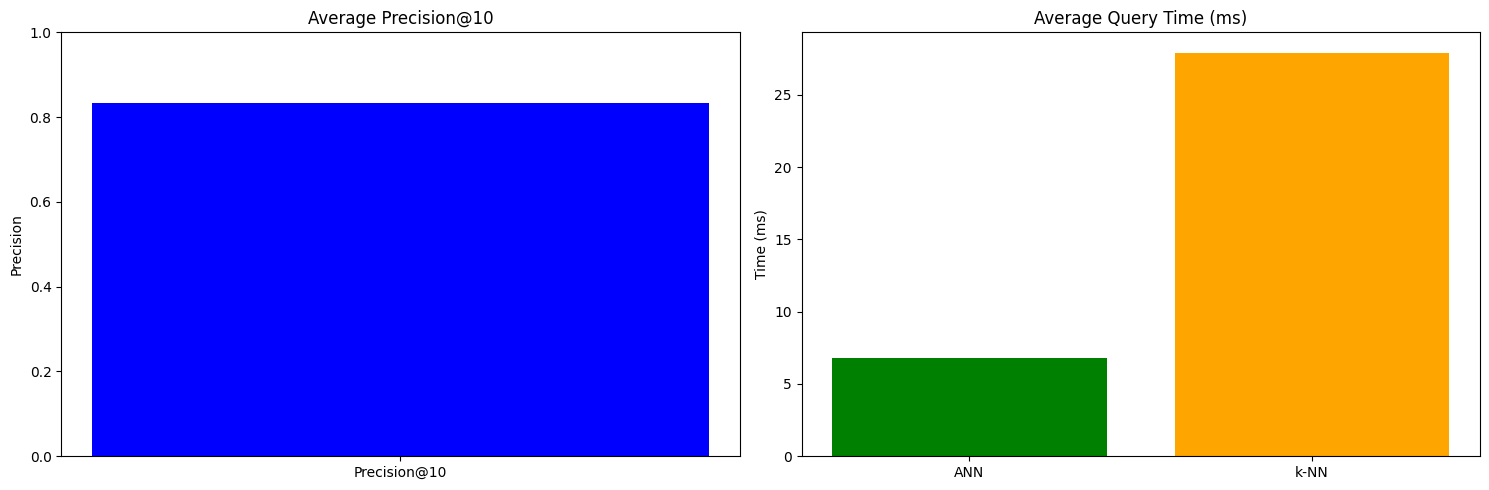

In [13]:
# Create a DataFrame for better visualization
results_df = pd.DataFrame({
    "Metric": ["Precision@10", "ANN Query Time (ms)", "k-NN Query Time (ms)", "Speedup Ratio"],
    "Value": [
        f"{results['avg_precision']:.4f}",
        f"{results['avg_ann_time'] * 1000:.2f}",
        f"{results['avg_knn_time'] * 1000:.2f}",
        f"{results['speedup_ratio']:.2f}x"
    ]
})

# Display the results
results_df

# Create a bar chart for visual comparison
import matplotlib.pyplot as plt

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot precision
ax1.bar(['Precision@10'], [results['avg_precision']], color='blue')
ax1.set_ylim(0, 1)
ax1.set_title('Average Precision@10')
ax1.set_ylabel('Precision')

# Plot query times
query_times = [results['avg_ann_time'] * 1000, results['avg_knn_time'] * 1000]
ax2.bar(['ANN', 'k-NN'], query_times, color=['green', 'orange'])
ax2.set_title('Average Query Time (ms)')
ax2.set_ylabel('Time (ms)')

plt.tight_layout()
plt.show()


## Using the evaluate_ann Function from qdrant_evaluation Module

We can also use the `evaluate_ann` function from the qdrant_evaluation module to get similar results.


In [14]:
# Use the evaluate_ann function from the module
module_results = evaluate_ann(client, COLLECTION_NAME, embeddings)

# Print the results
print(f"Average precision@{k}: {module_results['avg_precision']:.4f}")
print(f"Average ANN query time: {module_results['avg_query_time_ms']:.2f} ms")

# Create a DataFrame for the module results
module_df = pd.DataFrame({
    "Metric": ["Precision@10", "ANN Query Time (ms)"],
    "Value": [
        f"{module_results['avg_precision']:.4f}",
        f"{module_results['avg_query_time_ms']:.2f}"
    ]
})

# Display the DataFrame
module_df

# Compare our implementation with the module implementation
comparison_df = pd.DataFrame({
    "Metric": ["Precision@10", "ANN Query Time (ms)"],
    "Our Implementation": [
        f"{results['avg_precision']:.4f}",
        f"{results['avg_ann_time'] * 1000:.2f}"
    ],
    "Module Implementation": [
        f"{module_results['avg_precision']:.4f}",
        f"{module_results['avg_query_time_ms']:.2f}"
    ]
})

# Display the comparison
comparison_df


Average precision@10: 0.8340
Average ANN query time: 7.36 ms


,Metric,Our Implementation,Module Implementation
0,Precision@10,0.8340,0.8340
1,ANN Query Time (ms),6.80,7.36


## Conclusion

In this notebook, we evaluated the precision and performance of Qdrant's approximate nearest neighbor search compared to exact k-NN search. The results show:

1. The average precision@10 indicates how many of the approximate search results match the exact search results.
2. The average query times show the performance difference between approximate and exact search.
3. The speedup ratio demonstrates the performance advantage of using approximate search.

These metrics help us understand the trade-off between search accuracy and performance in vector databases like Qdrant.
